# Project - Third Requirement

### Include packages.

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Preliminar phase

### Environment

Let's define some types of non-stationary environments...

In [247]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

With sinusoidally-varying "true value".

In [248]:
# Here we model the probability of buying around the mean valuation as a gaussian distribution...
# ... but its mean keeps changing sinusoidally over time, with a fixed amplitude and period.
class PricingEnvironmentSingleProductSinusoidalMean(Environment):
    def __init__(self, cost, initial_mean_valuation, std_valuation, buyers_per_round, total_rounds, amplitude, period):
        self.cost = cost
        self.initial_mean_valuation = initial_mean_valuation
        self.std_valuation = std_valuation
        self.buyers_per_round = buyers_per_round
        self.total_rounds = total_rounds            # Needed to define the full cycle
        self.current_round = 0                      # To track time
        self.amplitude = amplitude                  # How much the mean valuation swings up and down
        self.period = period                        # How many rounds it takes to complete one full cycle

    def round(self, p_t):
        current_mean_valuation = self.initial_mean_valuation + self.amplitude * np.sin(2 * np.pi * self.current_round / self.period)

        # Probability of a single customer buying at price p_t
        # loc=current_mean_valuation means the center of the valuation distribution shifts
        prob_buy = 1 - norm.cdf(p_t, loc=current_mean_valuation, scale=self.std_valuation)

        # Ensure probability is within valid range [0, 1] due to extreme values in sine wave
        prob_buy = np.clip(prob_buy, 0, 1)

        # Number of sales is drawn from a binomial distribution
        num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        reward = (p_t - self.cost) * num_of_sales
        
        self.current_round += 1 # Advance the environment's internal clock
        return num_of_sales, reward

With steadily-increasing "true value".

In [249]:
class PricingEnvironmentSingleProductDriftingMean(Environment):
    def __init__(self, cost, initial_mean_valuation, std_valuation, buyers_per_round, drift_rate):
        self.cost = cost
        self.initial_mean_valuation = initial_mean_valuation
        self.std_valuation = std_valuation
        self.buyers_per_round = buyers_per_round
        self.drift_rate = drift_rate            # How much the mean valuation changes per round
        self.current_round = 0                  # To track time

    def round(self, p_t):
        current_mean_valuation = self.initial_mean_valuation + (self.current_round * self.drift_rate)

        # Probability of a single customer buying at price p_t
        # loc=current_mean_valuation means the center of the valuation distribution shifts
        prob_buy = 1 - norm.cdf(p_t, loc=current_mean_valuation, scale=self.std_valuation)

        # Ensure probability is within valid range [0, 1] (important if drift leads to very high/low valuations)
        prob_buy = np.clip(prob_buy, 0, 1)

        # Number of sales is drawn from a binomial distribution
        num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        reward = (p_t - self.cost) * num_of_sales
        
        self.current_round += 1 # Advance the environment's internal clock
        return num_of_sales, reward

### Now define the setting...

In [250]:
# --- Global Settings ---

N = 1                     # Number of products (unused in this version)
T = 20000                 # Time horizon (number of rounds)
n_trials = 10             # Number of independent trials for averaging

# --- Pricing Grid and Product Info ---

cost = 2.00                       # Unit production cost
initial_value = 5.00              # Initial mean valuation of the product
std_valuation = 1.0               # Standard deviation of customer valuations

min_p = 0.0
max_p = int(initial_value * 2)
K = 10                                  # Number of prices to test
P = np.linspace(min_p, max_p, K)        # Prices to test        

assert cost < initial_value , "Cost must be less than value"

# --- Market and Inventory Parameters ---

B = 120000 * N                          # Total inventory available (seller capacity)

amplitude = 2.0
period = 1000

drift_rate = initial_value / T

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50                   # Number of buyers per round per product
assert buyers_per_round >= 1, "Must have at least one buyer per round"

# --- Other Parameters ---

zoom_end_mini = 200         # Show only up to 200 rounds in mini plots
zoom_end = 2 * period       # Show only up to 2 periods
zoom_end_5 = 5000           # Start zooming 5k rounds
s = 30                      # random seed

### Design our agent

Since the environment is not stochastic, we choose an algorithm for adversarial environments to be used as primal regret minimizer of a primal-dual strategy. In particular, Hedge would require full feedback, so we adopt EXP3.P, while using gradient descent to minimize the Lagrange multiplier. The value of the learning rate has been tuned by manually running the experiment for 0.1, 0.01 and 0.001.

BEWARE: Tuning a lambda upperbound was NOT easy. The theorical result coming from the strong duality theorem was clipping the value of lambda to a range which was too small for the algorithm to learn "quick enough". We performed a manual grid search and noticed that values between *2\*max-price* and *3\*max-price* were a good tradeoff for both the second and the third experiments.

In [251]:
class EXP3P:
    def __init__(self, num_actions, gamma, eta, max_reward_scale):
        self.num_actions = num_actions
        self.gamma = gamma
        self.eta = eta
        self.weights = np.ones(num_actions)
        self.probabilities = np.zeros(num_actions)
        # Safe upper bound on absolute reward
        self.max_reward_scale = max_reward_scale

    def choose_action(self):
        sum_weights = np.sum(self.weights)
        self.probabilities = (1 - self.gamma) * (self.weights / sum_weights) + (self.gamma / self.num_actions)
        self.probabilities /= np.sum(self.probabilities)  # Just in case
        return np.random.choice(self.num_actions, p=self.probabilities)

    def update(self, chosen_action_idx, observed_reward):
        # Normalize reward and compute loss
        normalized_reward = observed_reward / self.max_reward_scale
        loss_t = (1 - normalized_reward) / 2
        estimated_loss = loss_t / self.probabilities[chosen_action_idx]
        self.weights[chosen_action_idx] *= np.exp(-self.eta * estimated_loss)

        # Normalize weights if needed
        w_sum = np.sum(self.weights)
        if w_sum < 1e-100 or w_sum > 1e100:
            self.weights /= np.max(self.weights)

class PrimalDualPricingAgent:
    def __init__(self, prices, B, T, cost, buyers_per_round, initial_lambda=0, learning_rate_lambda=0.01, exp3p_gamma=0.1, exp3p_eta=None):
        self.prices = prices
        self.K = len(prices)
        self.B = B
        self.T = T
        self.cost = cost
        self.buyers_per_round = buyers_per_round
        self.rho = B / T if T > 0 else 1e-8
        self.lambda_t = initial_lambda
        self.eta_lambda = learning_rate_lambda
        max_reward_scale = (max(prices) + cost + (T / B)) * buyers_per_round 
        self.num_sales = 0 ## ADDED FOR CHECK

        if exp3p_eta is None:
            exp3p_eta = np.sqrt(np.log(self.K) / (self.K * self.T))

        self.primal_regret_minimizer = EXP3P(num_actions=self.K, gamma=exp3p_gamma, eta=exp3p_eta, max_reward_scale=max_reward_scale)

        self.current_round = 0
        self.remaining_budget = B
        self.history_sales = []
        self.history_rewards = []
        self.history_effective_rewards = []
        self.history_lambda = [self.lambda_t]
        self.history_chosen_prices = []

    def choose_price(self):
        price_idx = self.primal_regret_minimizer.choose_action()
        price = self.prices[price_idx]
        self.history_chosen_prices.append(price)
        return price, price_idx

    def update(self, price_idx, num_of_sales, real_reward):
        price = self.prices[price_idx]
        effective_reward = (price - self.cost) * num_of_sales - self.lambda_t * ( num_of_sales - self.rho )

        self.primal_regret_minimizer.update(price_idx, effective_reward)
        self.history_effective_rewards.append(effective_reward)
        self.history_sales.append(num_of_sales)
        self.history_rewards.append(real_reward)

        rounds_left = self.T - self.current_round
        if rounds_left > 0:
            self.rho = self.remaining_budget / rounds_left
        else:
            self.rho = 0

        # Update lambda_t based on the difference between rho and num_of_sales
        diff = self.rho - num_of_sales
        lambda_update = - self.eta_lambda * diff
        self.lambda_t += lambda_update
        upper_bound_lambda = max(self.prices) * 2
        self.lambda_t = np.clip(self.lambda_t, 0, upper_bound_lambda)
        
        # --- START ADDED TO PLOT ---
        # print(f"[Round {self.current_round}] rho={self.rho:.4f} and num_of_sales={num_of_sales} ==> diff(rho - sales)={diff:.4f} ==> lambda_update={lambda_update:.6f}")
        # print(f"... because of upper_bound_lambda={upper_bound_lambda:.6f} due to min( 1 / rho = {self.rho:.4f}, max_price = {max(self.prices):.2f}")
        # --- END ADDED TO PLOT ---

        self.history_lambda.append(self.lambda_t)

        self.num_sales = num_of_sales
        self.remaining_budget -= num_of_sales
        self.current_round += 1

        if self.remaining_budget < 1:
            print(f"Terminated at round {self.current_round} due to budget.")
            return False
        return True

## First experiment

### Run in sinusoidal environment

In [252]:
# --- Simulation ---
all_rewards = []      # Shape: (n_trials, T)
all_lambdas = []      # Shape: (n_trials, <=T+1)
all_rho = []          # Shape: (n_trials, <=T)
all_sold_pieces = []  # Shape: (n_trials, <=T)

for seed in range(n_trials):
    
    # Set up environment
    np.random.seed(seed)
    env = PricingEnvironmentSingleProductSinusoidalMean(cost=cost, initial_mean_valuation=initial_value, std_valuation=std_valuation, buyers_per_round=buyers_per_round, total_rounds=T, amplitude=amplitude, period=period)
    
    # Initialize agent
    agent = PrimalDualPricingAgent(prices=P, B=B, T=T, cost=cost, buyers_per_round=buyers_per_round, initial_lambda=initial_value, exp3p_eta=None)
    
    rewards = np.zeros(T)
    rho_values = []
    sold_pieces_values = []

    for t in range(T):
        price, idx = agent.choose_price()
        sales, reward = env.round(price)
        cont = agent.update(idx, sales, reward)
        rewards[t] = reward
        if not cont:
            rewards[t+1:] = 0
            break
        rho_values.append(agent.rho)
        sold_pieces_values.append(agent.num_sales)

    # Store all trial data
    all_rewards.append(np.cumsum(rewards))
    all_lambdas.append(agent.history_lambda)
    all_rho.append(rho_values)
    all_sold_pieces.append(sold_pieces_values)

# --- Analysis and Plotting ---
all_rewards = np.array(all_rewards)                            # Shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

# Pad all_lambdas to the same length (T+1) with np.nan
# Convert to array with NaNs padded
all_lambdas_padded = [l + [np.nan] * (T + 1 - len(l)) for l in all_lambdas]
all_lambdas = np.array(all_lambdas_padded)  # shape: (n_trials, T+1)

# Compute only for valid (non-empty) rounds
valid_mask = ~np.isnan(all_lambdas).all(axis=0)  # which time steps have at least one non-NaN
mean_lambda = np.full(T + 1, np.nan)
std_lambda = np.full(T + 1, np.nan)

mean_lambda[valid_mask] = np.nanmean(all_lambdas[:, valid_mask], axis=0)
std_lambda[valid_mask] = np.nanstd(all_lambdas[:, valid_mask], axis=0)

### Plot Utility

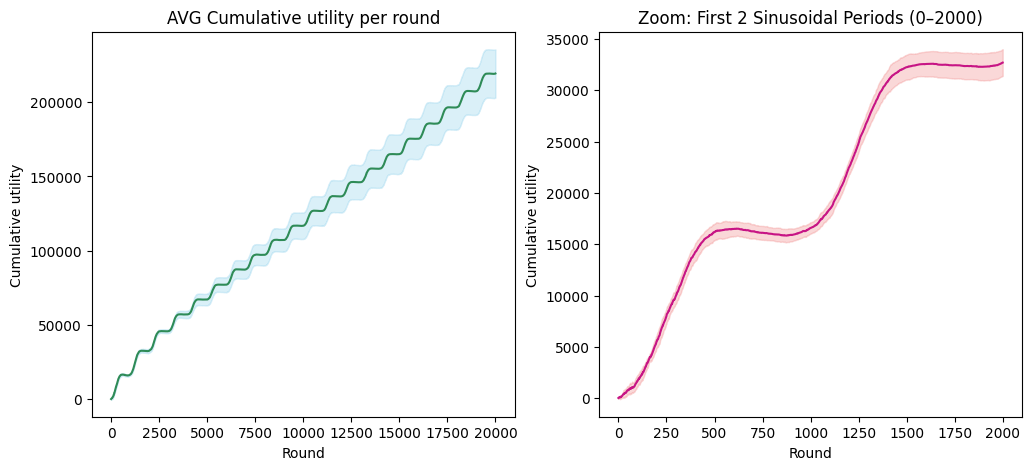

In [253]:
plt.figure(figsize=(12, 5))

# --- Full cumulative utility plot ---
plt.subplot(1, 2, 1)
plt.plot(mean_cum_util, color='seagreen', label='Cumulative utility')
plt.fill_between(np.arange(T), mean_cum_util - std_cum_util, mean_cum_util + std_cum_util, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
plt.title('AVG Cumulative utility per round')

# --- Zoomed plot for first two periods ---
plt.subplot(1, 2, 2)
plt.plot(np.arange(zoom_end), mean_cum_util[:zoom_end], color='mediumvioletred', label='Zoomed view (first 2 periods)')
plt.fill_between(np.arange(zoom_end), mean_cum_util[:zoom_end] - std_cum_util[:zoom_end], mean_cum_util[:zoom_end] + std_cum_util[:zoom_end], color='lightcoral', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
_ = plt.title(f'Zoom: First {2} Sinusoidal Periods (0–{zoom_end})')

### Plot Regret

Compute which fixed arm guarantees best optimization of the budget in order to get the maximum reward over R rounds.

In [254]:
print(f">>> Cumulative utility after {T} rounds: {mean_cum_util[-1]:.2f} ± {std_cum_util[-1]:.2f}")

# Generate sinusoidal mean valuations for each round
mean_valuations = initial_value + amplitude * np.sin(2 * np.pi * np.arange(T) / period)

# Initialize remaining budget and cumulative reward tracker
remaining_budget_clairvoyant = B
clairvoyant_cum_rewards = []
cum_reward = 0

# Initialize stats for each arm
arm_stats = {
    p: {
        "reward": 0.0,
        "budget_spent": 0.0,
        "cum_rewards": [],
    }
    for p in P if p > cost
}

clairvoyant_nobudget_cum_rewards = []
cum_reward_nobudget = 0

for t in range(T):
    mu_t = mean_valuations[t]  # Mean valuation at round t

    # Clairvoyant (no budget) chooses best price at this round
    best_reward_this_round = -np.inf

    for p in arm_stats:
        prob_buy = 1 - norm.cdf(p, loc=mu_t, scale=std_valuation)
        expected_sales = prob_buy * buyers_per_round
        reward = expected_sales * (p - cost)

        if reward > best_reward_this_round:
            best_reward_this_round = reward

    cum_reward_nobudget += best_reward_this_round
    clairvoyant_nobudget_cum_rewards.append(cum_reward_nobudget)

    for p in arm_stats:
        stats = arm_stats[p]

        if stats["budget_spent"] >= B:
            # No budget left, just append the last reward
            stats["cum_rewards"].append(stats["reward"])
            continue

        # Probability someone buys at price p
        prob_buy = 1 - norm.cdf(p, loc=mu_t, scale=std_valuation)
        expected_sales = prob_buy * buyers_per_round

        # Total cost to serve these expected sales
        expected_cost = expected_sales * p

        # Clip sales if over budget
        max_sales_affordable = (B - stats["budget_spent"]) / p
        actual_sales = min(expected_sales, max_sales_affordable)
        actual_cost = actual_sales * p
        actual_reward = actual_sales * (p - cost)

        # Update stats
        stats["budget_spent"] += actual_cost
        stats["reward"] += actual_reward
        stats["cum_rewards"].append(stats["reward"])

print("\n--- Summary: Reward and Budget Used per Price (Arm) ---")
print(f"{'Price':>8} | {'Total Reward':>20} | {'Budget Used':>20}")
print("-" * 55)
for p in sorted(arm_stats):
    r = arm_stats[p]["reward"]
    b = arm_stats[p]["budget_spent"]
    print(f"{p:8.2f} | {r:20,.2f} | {b:20,.2f}")

best_arm = max(arm_stats, key=lambda p: arm_stats[p]["reward"])
print(f">>> Best arm: price = {best_arm}, reward = {arm_stats[best_arm]['reward']:.2f}\n")
print(f">>> Clairvoyant (no-budget): total reward = {cum_reward_nobudget:.2f}")

>>> Cumulative utility after 20000 rounds: 219320.58 ± 16263.03

--- Summary: Reward and Budget Used per Price (Arm) ---
   Price |         Total Reward |          Budget Used
-------------------------------------------------------
    2.22 |            12,000.00 |           120,000.00
    3.33 |            48,000.00 |           120,000.00
    4.44 |            66,000.00 |           120,000.00
    5.56 |            76,800.00 |           120,000.00
    6.67 |            84,000.00 |           120,000.00
    7.78 |            89,142.86 |           120,000.00
    8.89 |            36,992.52 |            47,732.28
   10.00 |             1,664.83 |             2,081.04
>>> Best arm: price = 7.777777777777779, reward = 89142.86

>>> Clairvoyant (no-budget): total reward = 1797877.98


And plot it.

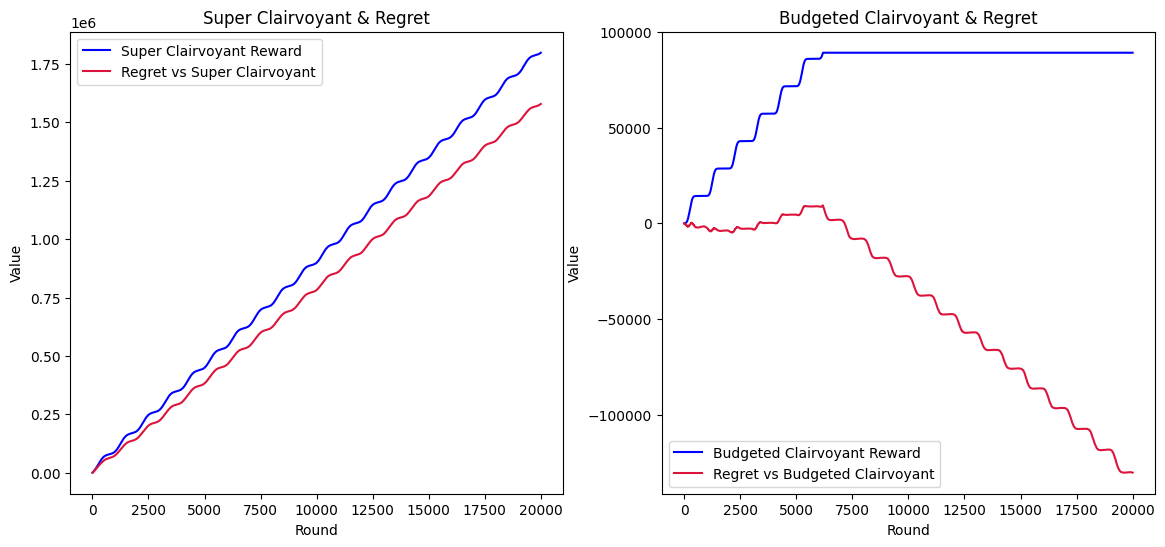

In [255]:
# New clairvoyant strategy without budget and no fixed arm
clairvoyant_nobudget_cum_rewards = np.array(clairvoyant_nobudget_cum_rewards)
regret_nobudget = clairvoyant_nobudget_cum_rewards - mean_cum_util

# Compute regret against clairvoyant strategy
clairvoyant_cum_rewards = np.array(arm_stats[best_arm]["cum_rewards"])
regret_budget = clairvoyant_cum_rewards - mean_cum_util

# Find first round where no more reward is collected (flat cumulative reward)
budget_exhausted_round = np.argmax(np.isclose(np.diff(mean_cum_util), 0, atol=1e-8)) + 1

# Create combined plot
plt.figure(figsize=(14, 6))

# --- Subplot 1: No-Budget Clairvoyant ---
plt.subplot(1, 2, 1)
plt.plot(clairvoyant_nobudget_cum_rewards, label='Super Clairvoyant Reward', color='blue')
plt.plot(regret_nobudget, label='Regret vs Super Clairvoyant', color='crimson')
plt.xlabel("Round")
plt.ylabel("Value")
plt.title("Super Clairvoyant & Regret")
plt.legend()

# --- Subplot 2: Budget Clairvoyant ---
plt.subplot(1, 2, 2)
plt.plot(clairvoyant_cum_rewards, label='Budgeted Clairvoyant Reward', color='blue')
plt.plot(regret_budget, label='Regret vs Budgeted Clairvoyant', color='crimson')
plt.xlabel("Round")
plt.ylabel("Value")
plt.title("Budgeted Clairvoyant & Regret")
_ = plt.legend()

### Plot λ (Lambda) over time

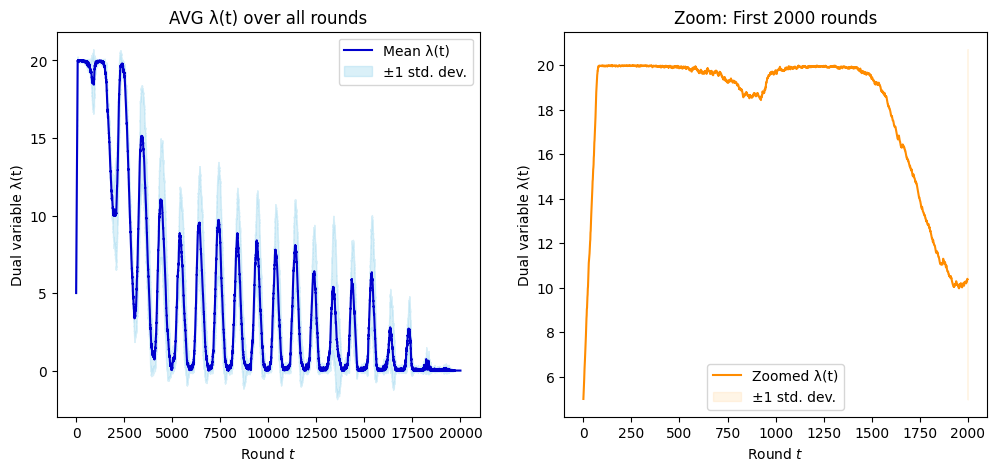

In [256]:
# How important was our constraint during the rounds?
plt.figure(figsize=(12, 5))

# --- Plot of λ(t) ---
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(mean_lambda)), mean_lambda, label='Mean λ(t)', color='mediumblue')
plt.fill_between(np.arange(len(mean_lambda)), mean_lambda - std_lambda, mean_lambda + std_lambda, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.title('AVG λ(t) over all rounds')
plt.legend()

# --- Zoom on first 2000 rounds ---
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(mean_lambda))[:zoom_end], mean_lambda[:zoom_end], label='Zoomed λ(t)', color='darkorange')
plt.fill_between(np.arange(len(mean_lambda))[zoom_end], mean_lambda[:zoom_end] - std_lambda[:zoom_end], mean_lambda[:zoom_end] + std_lambda[:zoom_end], color='navajowhite', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.title(f'Zoom: First {zoom_end} rounds')
_ = plt.legend()

### Plotting ρ (rho) vs Cost per round

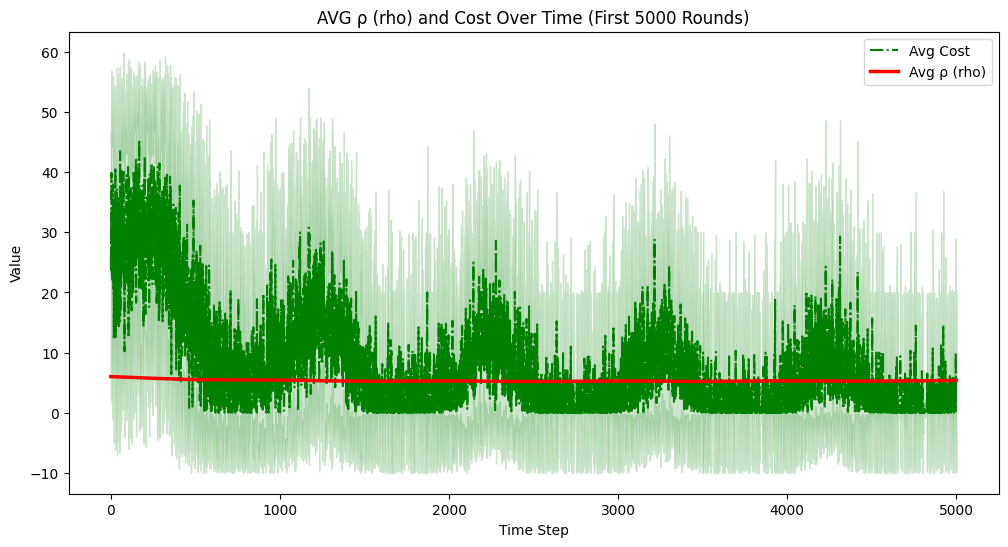

In [257]:
max_len = max(len(r) for r in all_rho)  # max length among trials
all_rho_padded = [r + [np.nan]*(max_len - len(r)) for r in all_rho]
all_sold_pieces_padded = [s + [np.nan]*(max_len - len(s)) for s in all_sold_pieces]

all_rho_array = np.array(all_rho_padded)           
all_sold_pieces_array = np.array(all_sold_pieces_padded)

mean_rho = np.nanmean(all_rho_array, axis=0)
std_rho = np.nanstd(all_rho_array, axis=0)
mean_sold_pieces = np.nanmean(all_sold_pieces_array, axis=0)
std_sold_pieces = np.nanstd(all_sold_pieces_array, axis=0)

time_steps = np.arange(max_len)  # use max_len here!

plt.figure(figsize=(12, 6))

plt.plot(time_steps[:zoom_end_5], mean_sold_pieces[:zoom_end_5], label='Avg Cost', color='green', linestyle='-.')
plt.fill_between(time_steps[:zoom_end_5], mean_sold_pieces[:zoom_end_5] - std_sold_pieces[:zoom_end_5], mean_sold_pieces[:zoom_end_5] + std_sold_pieces[:zoom_end_5], color='green', alpha=0.2)

plt.plot(time_steps[:zoom_end_5], mean_rho[:zoom_end_5], label='Avg ρ (rho)', color='red', linewidth=2.5, zorder=3)
plt.fill_between(time_steps[:zoom_end_5], mean_rho[:zoom_end_5] - std_rho[:zoom_end_5], mean_rho[:zoom_end_5] + std_rho[:zoom_end_5], color='red', alpha=0.2)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title(f'AVG ρ (rho) and Cost Over Time (First {zoom_end_5} Rounds)')
_ = plt.legend()

## Second experiment

### Now with drifting increasing environment

In [258]:
# --- Simulation ---
all_rewards = []      # Shape: (n_trials, T)
all_lambdas = []      # Shape: (n_trials, <=T+1)
all_rho = []          # Shape: (n_trials, <=T)
all_sold_pieces = []  # Shape: (n_trials, <=T)

for seed in range(n_trials):
    
    # Set up environment
    np.random.seed(seed)
    env = PricingEnvironmentSingleProductDriftingMean(cost=cost, initial_mean_valuation=initial_value, std_valuation=std_valuation, buyers_per_round=buyers_per_round, drift_rate=drift_rate)
    
    # Initialize agent
    agent = PrimalDualPricingAgent(prices=P, B=B, T=T, cost=cost, buyers_per_round=buyers_per_round, initial_lambda=initial_value, exp3p_eta=None)
    
    rewards = np.zeros(T)
    rho_values = []
    sold_pieces_values = []

    for t in range(T):
        price, idx = agent.choose_price()
        sales, reward = env.round(price)
        cont = agent.update(idx, sales, reward)
        rewards[t] = reward
        if not cont:
            rewards[t+1:] = 0
            break
        rho_values.append(agent.rho)
        sold_pieces_values.append(agent.num_sales)

    # Store all trial data
    all_rewards.append(np.cumsum(rewards))
    all_lambdas.append(agent.history_lambda)
    all_rho.append(rho_values)
    all_sold_pieces.append(sold_pieces_values)

# --- Analysis and Plotting ---
all_rewards = np.array(all_rewards)                            # Shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

# Pad all_lambdas to the same length (T+1) with np.nan
# Convert to array with NaNs padded
all_lambdas_padded = [l + [np.nan] * (T + 1 - len(l)) for l in all_lambdas]
all_lambdas = np.array(all_lambdas_padded)  # shape: (n_trials, T+1)

# Compute only for valid (non-empty) rounds
valid_mask = ~np.isnan(all_lambdas).all(axis=0)  # which time steps have at least one non-NaN
mean_lambda = np.full(T + 1, np.nan)
std_lambda = np.full(T + 1, np.nan)

mean_lambda[valid_mask] = np.nanmean(all_lambdas[:, valid_mask], axis=0)
std_lambda[valid_mask] = np.nanstd(all_lambdas[:, valid_mask], axis=0)

Terminated at round 15642 due to budget.
Terminated at round 15643 due to budget.
Terminated at round 15631 due to budget.
Terminated at round 15126 due to budget.
Terminated at round 15625 due to budget.
Terminated at round 15186 due to budget.
Terminated at round 15498 due to budget.
Terminated at round 15445 due to budget.
Terminated at round 16130 due to budget.
Terminated at round 15552 due to budget.


### Plot Regret

Compute.

In [259]:
print(f">>> Cumulative utility after {T} rounds: {mean_cum_util[-1]:.2f} ± {std_cum_util[-1]:.2f}")

# Generate sinusoidal mean valuations for each round
mean_valuations = initial_value + np.arange(T) * drift_rate

# Initialize remaining budget and cumulative reward tracker
remaining_budget_clairvoyant = B
clairvoyant_cum_rewards = []
cum_reward = 0

# Initialize stats for each arm
arm_stats = {
    p: {
        "reward": 0.0,
        "budget_spent": 0.0,
        "cum_rewards": [],
    }
    for p in P if p > cost
}

clairvoyant_nobudget_cum_rewards = []
cum_reward_nobudget = 0

for t in range(T):
    mu_t = mean_valuations[t]  # Mean valuation at round t

    # Clairvoyant (no budget) chooses best price at this round
    best_reward_this_round = -np.inf

    for p in arm_stats:
        prob_buy = 1 - norm.cdf(p, loc=mu_t, scale=std_valuation)
        expected_sales = prob_buy * buyers_per_round
        reward = expected_sales * (p - cost)

        if reward > best_reward_this_round:
            best_reward_this_round = reward

    cum_reward_nobudget += best_reward_this_round
    clairvoyant_nobudget_cum_rewards.append(cum_reward_nobudget)

    for p in arm_stats:
        stats = arm_stats[p]

        if stats["budget_spent"] >= B:
            # No budget left, just append the last reward
            stats["cum_rewards"].append(stats["reward"])
            continue

        # Probability someone buys at price p
        prob_buy = 1 - norm.cdf(p, loc=mu_t, scale=std_valuation)
        expected_sales = prob_buy * buyers_per_round

        # Total cost to serve these expected sales
        expected_cost = expected_sales * p

        # Clip sales if over budget
        max_sales_affordable = (B - stats["budget_spent"]) / p
        actual_sales = min(expected_sales, max_sales_affordable)
        actual_cost = actual_sales * p
        actual_reward = actual_sales * (p - cost)

        # Update stats
        stats["budget_spent"] += actual_cost
        stats["reward"] += actual_reward
        stats["cum_rewards"].append(stats["reward"])

print("\n--- Summary: Reward and Budget Used per Price (Arm) ---")
print(f"{'Price':>8} | {'Total Reward':>20} | {'Budget Used':>20}")
print("-" * 55)
for p in sorted(arm_stats):
    r = arm_stats[p]["reward"]
    b = arm_stats[p]["budget_spent"]
    print(f"{p:8.2f} | {r:20,.2f} | {b:20,.2f}")

best_arm = max(arm_stats, key=lambda p: arm_stats[p]["reward"])
print(f">>> Best arm: price = {best_arm}, reward = {arm_stats[best_arm]['reward']:.2f}\n")
print(f">>> Clairvoyant (no-budget): total reward = {cum_reward_nobudget:.2f}")

>>> Cumulative utility after 20000 rounds: 408532.91 ± 11923.51

--- Summary: Reward and Budget Used per Price (Arm) ---
   Price |         Total Reward |          Budget Used
-------------------------------------------------------
    2.22 |            12,000.00 |           120,000.00
    3.33 |            48,000.00 |           120,000.00
    4.44 |            66,000.00 |           120,000.00
    5.56 |            76,800.00 |           120,000.00
    6.67 |            84,000.00 |           120,000.00
    7.78 |            89,142.86 |           120,000.00
    8.89 |            93,000.00 |           120,000.00
   10.00 |            96,000.00 |           120,000.00
>>> Best arm: price = 10.0, reward = 96000.00

>>> Clairvoyant (no-budget): total reward = 3765276.36


Plot.

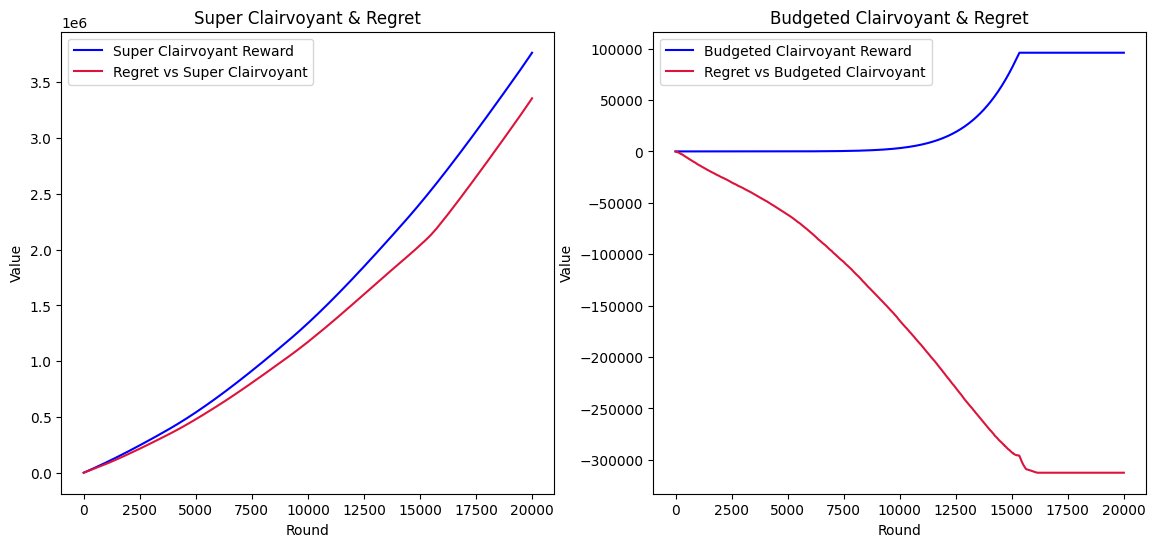

In [260]:
# New clairvoyant strategy without budget and no fixed arm
clairvoyant_nobudget_cum_rewards = np.array(clairvoyant_nobudget_cum_rewards)
regret_nobudget = clairvoyant_nobudget_cum_rewards - mean_cum_util

# Compute regret against clairvoyant strategy
clairvoyant_cum_rewards = np.array(arm_stats[best_arm]["cum_rewards"])
regret_budget = clairvoyant_cum_rewards - mean_cum_util

# Find first round where no more reward is collected (flat cumulative reward)
budget_exhausted_round = np.argmax(np.isclose(np.diff(mean_cum_util), 0, atol=1e-8)) + 1

# Create combined plot
plt.figure(figsize=(14, 6))

# --- Subplot 1: No-Budget Clairvoyant ---
plt.subplot(1, 2, 1)
plt.plot(clairvoyant_nobudget_cum_rewards, label='Super Clairvoyant Reward', color='blue')
plt.plot(regret_nobudget, label='Regret vs Super Clairvoyant', color='crimson')
plt.xlabel("Round")
plt.ylabel("Value")
plt.title("Super Clairvoyant & Regret")
plt.legend()

# --- Subplot 2: Budget Clairvoyant ---
plt.subplot(1, 2, 2)
plt.plot(clairvoyant_cum_rewards, label='Budgeted Clairvoyant Reward', color='blue')
plt.plot(regret_budget, label='Regret vs Budgeted Clairvoyant', color='crimson')
plt.xlabel("Round")
plt.ylabel("Value")
plt.title("Budgeted Clairvoyant & Regret")
_ = plt.legend()

### Plot λ (Lambda) over time

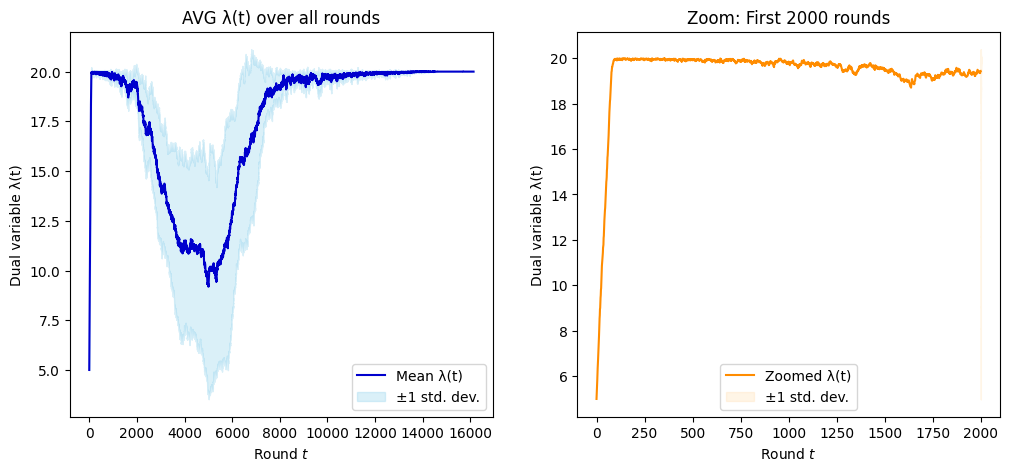

In [261]:
# How important was our constraint during the rounds?
plt.figure(figsize=(12, 5))

# --- Plot completo di λ(t) ---
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(mean_lambda)), mean_lambda, label='Mean λ(t)', color='mediumblue')
plt.fill_between(np.arange(len(mean_lambda)), mean_lambda - std_lambda, mean_lambda + std_lambda, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.title('AVG λ(t) over all rounds')
plt.legend()

# --- Zoom sui primi 2000 round ---
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(mean_lambda))[:zoom_end], mean_lambda[:zoom_end], label='Zoomed λ(t)', color='darkorange')
plt.fill_between(np.arange(len(mean_lambda))[zoom_end], mean_lambda[:zoom_end] - std_lambda[:zoom_end], mean_lambda[:zoom_end] + std_lambda[:zoom_end], color='navajowhite', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.title(f'Zoom: First {zoom_end} rounds')
_ = plt.legend()

### Plotting ρ (rho) vs Cost per round

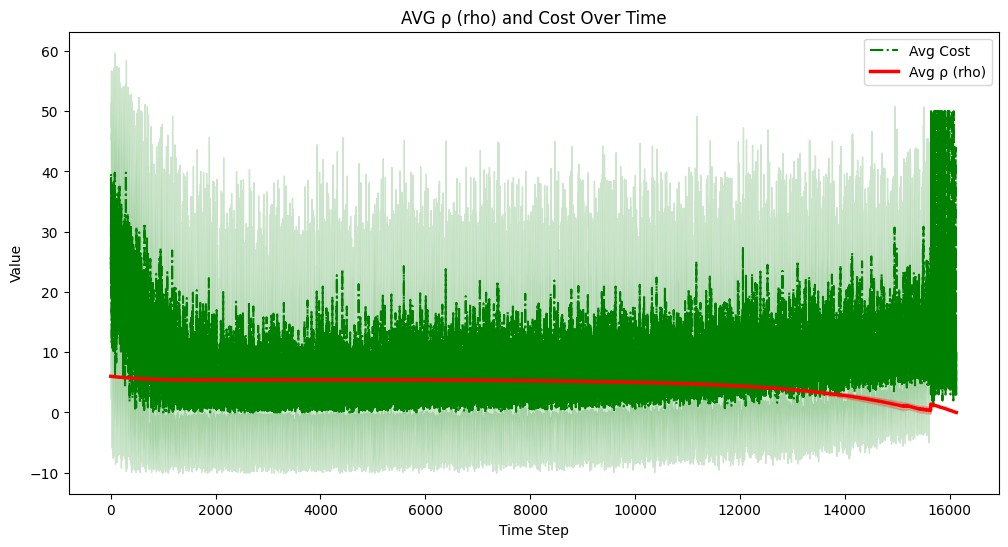

In [262]:
max_len = max(len(r) for r in all_rho)  # max length among trials
all_rho_padded = [r + [np.nan]*(max_len - len(r)) for r in all_rho]
all_sold_pieces_padded = [s + [np.nan]*(max_len - len(s)) for s in all_sold_pieces]

all_rho_array = np.array(all_rho_padded)           
all_sold_pieces_array = np.array(all_sold_pieces_padded)

mean_rho = np.nanmean(all_rho_array, axis=0)
std_rho = np.nanstd(all_rho_array, axis=0)
mean_sold_pieces = np.nanmean(all_sold_pieces_array, axis=0)
std_sold_pieces = np.nanstd(all_sold_pieces_array, axis=0)

time_steps = np.arange(max_len)  # use max_len here!

plt.figure(figsize=(12, 6))

plt.plot(time_steps, mean_sold_pieces, label='Avg Cost', color='green', linestyle='-.')
plt.fill_between(time_steps, mean_sold_pieces - std_sold_pieces, mean_sold_pieces + std_sold_pieces, color='green', alpha=0.2)

plt.plot(time_steps, mean_rho, label='Avg ρ (rho)', color='red', linewidth=2.5, zorder=3)
plt.fill_between(time_steps, mean_rho - std_rho, mean_rho + std_rho, color='red', alpha=0.2)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('AVG ρ (rho) and Cost Over Time')
_ = plt.legend()